In [99]:
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
import random
from keras import layers, losses
from keras.models import Model
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns

#é boa ideia fazermos transfer learning sem peso computacional do nosso lado nesta parte ao usarmos CNNs com weights pretreinados?

#
#----

#lista topicos para prof:
#onde colocar o nosso dataset para usar no servidor
#como ter um registo acessivel por nos dos outputs
#opiniao do prof sobre nossos metodos de extracao de features
#falar sobre orb e problemas que existem a tentar usar como metodo de extracao de feats

#----
#respostas:
#no servidor
#descer no less teste.py com space e subir para topo com b
#q para sair

#o que temos agora não é transfer learning

#testar autoencoder para feat. extract. (secalhar preferivel a orb)
#---- 

## Data

In [100]:
#path martim
#path = "../../../../DadosProj/UTKFace/"
#path alex
path = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


### Extraction with PreProcessing

**Changes to images with opencv methods**

- Obtain better contrast for images normalizing the ranges for colors for a pixel between 0 and 255
 - instance = cv2.normalize(instance, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

- Converting to YUV color model, equalizing color histogram to modify 
- distribution of colors taking luminosity into account and
- reconverting to RBG after doing histogram equalization
    - img_yuv = cv2.cvtColor(instance, cv2.COLOR_BGR2YUV)
    - img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    - instance = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

In [101]:
images = []
ages = []
genders = []
ethnicities = []
counter = 0

for file in files:
    if counter == 100:
        break
    
    image = cv2.imread(path+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(200, 200))
    image = image.reshape((image.shape[0], image.shape[1], 3)) ### A ausencia deste ponto  estava a causar o erro no ORB
    #image = image / 255.0 #normalizing values on each point 
    
    images.append(image)
    delimit = file.split('_')
    ages.append(int(delimit[0]))
    # first number is age (0-116 possible values)
    genders.append(int(delimit[1]))
    # second number is gender (0 for male, 1 for female)
    #ethnicities.append(int(delimit[2]))
    # third number is ethnicity (0 for white, 1 for black, 2 for asian, 3 for indian, 4 for any other ethnicity)

    counter += 1

In [102]:
X = np.squeeze(images)
X.shape

(100, 200, 200, 3)

### Age Classes
Classes choosen based on [US National Institute of Health](https://www.nih.gov/nih-style-guide/age):

- Neonates or newborns (birth to 1 month)
- Infants (1 month to 1 year)
- Children (1 year through 12 years)
- Adolescents (13 years through 17 years. They may also be referred to as teenagers depending on the context.)
- Adults (18 years or older)
- Older adults (65 and older)

In [103]:
print(type(ages))
print(len(ages))
unique_values = list(set(ages))
print(unique_values)

<class 'list'>
100
[100, 101, 103, 105, 10]


In [104]:
age_classes = []
for i in ages:
    i = int(i)
    if i <= 1:
        age_classes.append(0)
    if (i>1) and (i<=13):
        age_classes.append(1)
    if (i>13) and (i<17):
        age_classes.append(2)
    if (i>=17) and (i<30):
        age_classes.append(3)
    if (i>=30) and (i<60):
        age_classes.append(4)
    if i>=60:
        age_classes.append(5)

In [105]:
age_labels =["Baby",   # index 0
        "Infant",      # index 1
        "Adolescent",  # index 2 
        "Young Adult", # index 3 
        "Adult"        # index 4
        "Old Adult",   # index 5
        ]

In [106]:
from keras.utils.np_utils import to_categorical
age_categories = to_categorical(age_classes, num_classes=6)
age_categories[:20]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [107]:
print(len(age_classes))
print(type(age_classes))
unique_values = list(set(age_classes))
print(unique_values)

100
<class 'list'>
[1, 5]


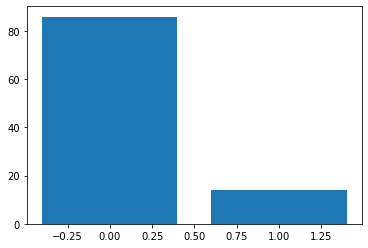

Max value: 1


In [108]:
x_genders = list(set(genders))
y_genders= [genders.count(i) for i in x_genders]
plt.bar(x_genders,y_genders)
plt.show()
print("Max value:",max(genders))

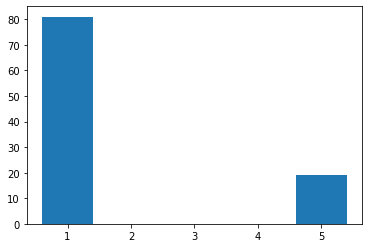

Max value: 5


In [109]:
x_ages = list(set(age_classes))
y_ages = [age_classes.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(age_classes))

In [110]:
img_all = pd.DataFrame()
img_all["age"] = age_classes
img_all["gender"] = genders

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = age_classes

print("age\n", img_age.age.value_counts())
print("gender\n", img_gender.gender.value_counts())

age
 1    81
5    19
Name: age, dtype: int64
gender
 0    86
1    14
Name: gender, dtype: int64


Gender Class: 1 Age Class: 5


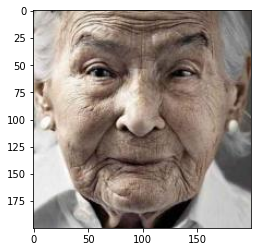

In [111]:
def display(img):
    plt.imshow(img)
    plt.show()
    
idx = 9
if idx < len(images):
    sample = images[idx]
    print("Gender Class:", genders[idx], "Age Class:", age_classes[idx])
    display(sample)
else:
    print(f"Index {idx} is out of range for the list of {len(images)} images")

## Base SVM

In [17]:
flattened_images = []

for image in images:
    flattened_image = image.flatten()
    flattened_images.append(flattened_image)

flattened_images_array = np.array(flattened_images)

print(flattened_images_array.shape)

(2000, 120000)


In [18]:
for i, arr in enumerate(flattened_images_array):
    print(f"Descriptor array {i} shape: {arr.shape}")

Descriptor array 0 shape: (120000,)
Descriptor array 1 shape: (120000,)
Descriptor array 2 shape: (120000,)
Descriptor array 3 shape: (120000,)
Descriptor array 4 shape: (120000,)
Descriptor array 5 shape: (120000,)
Descriptor array 6 shape: (120000,)
Descriptor array 7 shape: (120000,)
Descriptor array 8 shape: (120000,)
Descriptor array 9 shape: (120000,)
Descriptor array 10 shape: (120000,)
Descriptor array 11 shape: (120000,)
Descriptor array 12 shape: (120000,)
Descriptor array 13 shape: (120000,)
Descriptor array 14 shape: (120000,)
Descriptor array 15 shape: (120000,)
Descriptor array 16 shape: (120000,)
Descriptor array 17 shape: (120000,)
Descriptor array 18 shape: (120000,)
Descriptor array 19 shape: (120000,)
Descriptor array 20 shape: (120000,)
Descriptor array 21 shape: (120000,)
Descriptor array 22 shape: (120000,)
Descriptor array 23 shape: (120000,)
Descriptor array 24 shape: (120000,)
Descriptor array 25 shape: (120000,)
Descriptor array 26 shape: (120000,)
Descriptor 

### gender

In [26]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_array, genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 1600
Samples in Testing: 400


In [1]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
y_pred = clf.predict(X_test)

#mcc = matthews_corrcoef(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
#print("MCC: ", mcc)
#print("Accuracy: ", accuracy)
print(classification_report(y_test, y_pred))
#confusion_matrix(y_test, y_pred)

labelGender = list(set(genders))

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labelGender, yticklabels=labelGender)

# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

NameError: name 'SVC' is not defined

### age

In [20]:
X_train, X_test, y_train, y_test = train_test_split(flattened_images_array, age_categories, test_size=0.2, random_state=42)
#print("Samples in Training:",X_train.shape[0])
#print("Samples in Testing:",X_test.shape[0])

In [22]:
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 1600
Samples in Testing: 400


MCC:  0.4745556702691851
Accuracy:  0.595


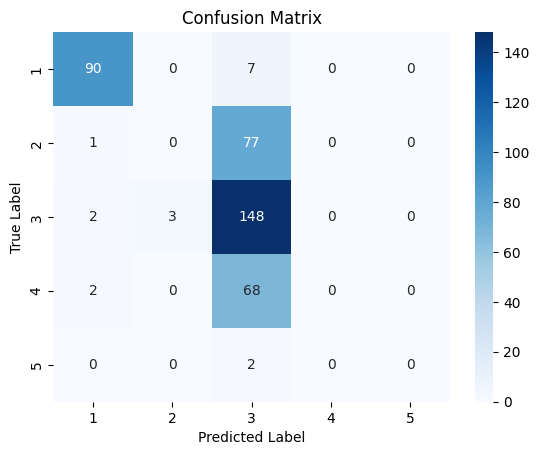

In [21]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
y_pred = clf.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("MCC: ", mcc)
print("Accuracy: ", accuracy)
#print(classification_report(y_test, y_pred))


labelAge = list(set(age_categories))
# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
# create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labelAge, yticklabels=labelAge)
# set plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Base CNN 

### age

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, age_categories, test_size=0.2,shuffle  = True)

In [23]:
def CNN (input_shape, output, activation):
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_shape)) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(output, activation=activation))
    
    model.summary()
    
    return model

In [24]:
model = CNN((200,200,3), 6, 'softmax')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 50, 50, 32)       

In [25]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = model.fit(X_train, y_train,
        batch_size=8,
        epochs=2,
        validation_data=(X_test, y_test),)

Epoch 1/2
10/10 [==============================] - 6s 458ms/step - loss: 1.8663 - accuracy: 0.7125 - val_loss: 1.1928 - val_accuracy: 0.8000
Epoch 2/2
10/10 [==============================] - 4s 410ms/step - loss: 0.7426 - accuracy: 0.7750 - val_loss: 1.5840 - val_accuracy: 0.8000


In [26]:
def cnn_metrics (X_test, y_test, classes):
    preds = []
    truth = []
    y_hat = model.predict(X_test)

    for i in range(X_test.shape[0]):
        
        predict_index = np.argmax(y_hat[i])
        preds.append(predict_index) 
        
        true_index = np.argmax(y_test[i])
        truth.append(true_index)
        
    mcc = matthews_corrcoef(truth, preds)
    print("MCC: ", mcc)

    label = list(set(classes))

    cm = confusion_matrix(truth, preds)

    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=label, yticklabels=label)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    plt.show()

    print(classification_report(truth, preds))
    
    """ y_hat = model.predict(X_test)

    # Plot a random sample of 10 test images, their predicted labels and ground truth
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
        ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(x_test[index]))
        predict_index = np.argmax(y_hat[index])
        #print(predict_index)
        true_index = np.argmax(y_test[index])
        #print(true_index)
        # Set the title for each image
        ax.set_title("{} ({})".format(labels[predict_index], 
                                    labels[true_index]),
                                    color=("green" if predict_index == true_index else "red"))"""

1/1 [==============================] - 0s 269ms/step
MCC:  0.0


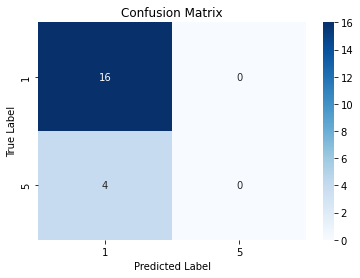

              precision    recall  f1-score   support

           1       0.80      1.00      0.89        16
           5       0.00      0.00      0.00         4

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20



c:\Users\afbso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\afbso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\afbso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cnn_metrics(X_test, y_test, age_classes)

### gender

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=42)

In [51]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [52]:
X_train.shape

(80, 200, 200, 3)

In [44]:
model = CNN((200,200,3), 1, 'sigmoid')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 100, 100, 64)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 50, 50, 32)       

In [33]:
#for age use categorical_crossentropy instead
model.compile(optimizer="adam", loss="binary_crossentropy")

history_base_gender = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/3
3/3 [==============================] - 4s 976ms/step - loss: 5.8916 - val_loss: 5.0455
Epoch 2/3
3/3 [==============================] - 3s 883ms/step - loss: 4.4022 - val_loss: 0.5849
Epoch 3/3
3/3 [==============================] - 3s 837ms/step - loss: 1.2024 - val_loss: 0.5976


1/1 [==============================] - 0s 167ms/step
MCC:  0.0


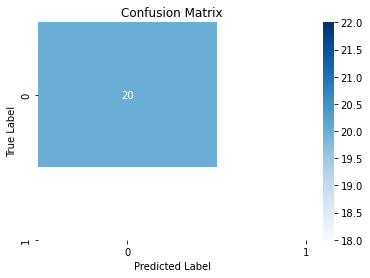

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [34]:
cnn_metrics(X_test, y_test, genders)

## Feature extraction methods

- Sure! This code extracts Histogram of Oriented Gradients (HOG) features from a list of preprocessed images, normalizes the features to have zero mean and unit variance, and stores them in a NumPy array called hog_features_norm

In [41]:
#gray_images = np.array([rgb2gray(image) for image in images]) #just in case we need the images in greys

### HOG

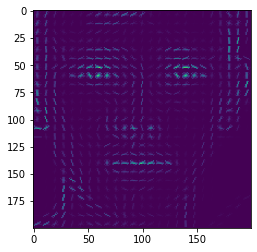

In [42]:
image_check = images[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

In [36]:
# Extract HOG features from the images
hog_features = []
for img in images:
    #hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
    #                cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

In [37]:
for i, arr in enumerate(hog_features_norm):
    print(f"Descriptor array {i} shape: {arr.shape}")

Descriptor array 0 shape: (20736,)
Descriptor array 1 shape: (20736,)
Descriptor array 2 shape: (20736,)
Descriptor array 3 shape: (20736,)
Descriptor array 4 shape: (20736,)
Descriptor array 5 shape: (20736,)
Descriptor array 6 shape: (20736,)
Descriptor array 7 shape: (20736,)
Descriptor array 8 shape: (20736,)
Descriptor array 9 shape: (20736,)
Descriptor array 10 shape: (20736,)
Descriptor array 11 shape: (20736,)
Descriptor array 12 shape: (20736,)
Descriptor array 13 shape: (20736,)
Descriptor array 14 shape: (20736,)
Descriptor array 15 shape: (20736,)
Descriptor array 16 shape: (20736,)
Descriptor array 17 shape: (20736,)
Descriptor array 18 shape: (20736,)
Descriptor array 19 shape: (20736,)
Descriptor array 20 shape: (20736,)
Descriptor array 21 shape: (20736,)
Descriptor array 22 shape: (20736,)
Descriptor array 23 shape: (20736,)
Descriptor array 24 shape: (20736,)
Descriptor array 25 shape: (20736,)
Descriptor array 26 shape: (20736,)
Descriptor array 27 shape: (20736,)
De

- For each preprocessed image in images, extract the HOG features using the hog() function from scikit-image. The orientations, pixels_per_cell, and cells_per_block parameters control the number of orientations, the size of the cells, and the number of cells per block used in the feature extraction process. The transform_sqrt parameter applies power law compression to normalize the local contrast of the image. The feature_vector parameter flattens the HOG descriptor into a 1D array. The multichannel and channel_axis parameters are used to indicate that the input image has three channels. The resulting HOG feature is then appended to the hog_features list.

#### SVM

##### gender

In [119]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 400
Samples in Testing: 100


In [120]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.78


##### age

In [121]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, age_categories, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 400
Samples in Testing: 100


In [122]:
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.64


#### CNN

##### gender

In [80]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 144, 144, 1)       0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 72, 72, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 72, 72, 32)        320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 18, 18, 64)     

In [81]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)

In [82]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [83]:
cnn.compile(optimizer="adam", loss="binary_crossentropy")

history = cnn.fit(X_train, y_train,
                    epochs=2,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/2
3/3 [==============================] - 1s 164ms/step - loss: 0.5850 - val_loss: 1.3235
Epoch 2/2
3/3 [==============================] - 0s 97ms/step - loss: 0.5552 - val_loss: 0.5305


In [84]:
cnn_metrics(X_test, y_test, genders)

ValueError: in user code:

    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 200, 200, 3), found shape=(None, 20736)


##### age

In [ ]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, age_categories, test_size=0.2,shuffle  = True)

In [74]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [78]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history_base_age = cnn.fit(X_train, y_train,
        batch_size=8,
        epochs=2,
        validation_data=(X_test, y_test),)

Epoch 1/2
10/10 [==============================] - 2s 65ms/step - loss: 1.0275 - accuracy: 0.6500 - val_loss: 0.7676 - val_accuracy: 0.8500
Epoch 2/2
10/10 [==============================] - 0s 47ms/step - loss: 0.5463 - accuracy: 0.8500 - val_loss: 0.6676 - val_accuracy: 0.7000


### ORB (Oriented FAST and Rotated BRIEF)

adaptado ao fazer tambem:

-definir um threshold minimo para aceitar conjunto de descriptors para uma imagem

-escolher aleatoriamente uma quantidade fixa de descriptors para uma imagem e operar apenas com essa quantidade para essa imagem


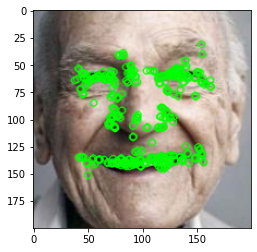

In [112]:
image_check = images[1]

orb = cv2.ORB_create()


kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

In [124]:
image[0].shape

(200, 3)

In [113]:
# define minimum and maximum keypoints
MIN_KEYPOINTS = 100
orb_features = []
Genders = []
Age = []

# loop over images and keypoints
for i, img in enumerate(images):
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints)
    keypoints = list(keypoints)    
    # check if number of keypoints is between min and max
    if len(keypoints) < MIN_KEYPOINTS:
        continue
        
    # remove extra keypoints randomly
    while len(keypoints) > MIN_KEYPOINTS:
        idx = random.randint(0, len(keypoints)-1)
        keypoints.pop(idx)
        descriptors = np.delete(descriptors, idx, axis=0)
        
    # add descriptors to feature list
    orb_features.append(np.ndarray.flatten(descriptors))
    Genders.append(genders[i])
    Age.append(age_categories[i])

In [133]:
print(len(Genders))
print(len(orb_features))

361
361


In [134]:
for i, arr in enumerate(orb_features):
    print(f"Descriptor array {i} shape: {arr.shape}")

Descriptor array 0 shape: (3200,)
Descriptor array 1 shape: (3200,)
Descriptor array 2 shape: (3200,)
Descriptor array 3 shape: (3200,)
Descriptor array 4 shape: (3200,)
Descriptor array 5 shape: (3200,)
Descriptor array 6 shape: (3200,)
Descriptor array 7 shape: (3200,)
Descriptor array 8 shape: (3200,)
Descriptor array 9 shape: (3200,)
Descriptor array 10 shape: (3200,)
Descriptor array 11 shape: (3200,)
Descriptor array 12 shape: (3200,)
Descriptor array 13 shape: (3200,)
Descriptor array 14 shape: (3200,)
Descriptor array 15 shape: (3200,)
Descriptor array 16 shape: (3200,)
Descriptor array 17 shape: (3200,)
Descriptor array 18 shape: (3200,)
Descriptor array 19 shape: (3200,)
Descriptor array 20 shape: (3200,)
Descriptor array 21 shape: (3200,)
Descriptor array 22 shape: (3200,)
Descriptor array 23 shape: (3200,)
Descriptor array 24 shape: (3200,)
Descriptor array 25 shape: (3200,)
Descriptor array 26 shape: (3200,)
Descriptor array 27 shape: (3200,)
Descriptor array 28 shape: (32

In [116]:
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

#### SVM

##### gender

In [129]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, Genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 288
Samples in Testing: 73


In [130]:
clf = SVC()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5616438356164384


##### age

In [136]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, Age, test_size=0.2, random_state=42)

In [137]:
clf = SVC()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6986301369863014


#### CNN

##### gender

In [122]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, Genders, test_size=0.2, random_state=42)

In [123]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [127]:
X_train.shape

(64, 3200)

In [124]:
cnn = Sequential()

#tratado
cnn.add(layers.Reshape((144, 144, 1), input_shape=X_train.shape[0]))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

TypeError: 'int' object is not iterable

In [120]:
cnn.compile(optimizer="adam", loss="binary_crossentropy")

history = cnn.fit(X_train, y_train,
                    epochs=2,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/2


ValueError: in user code:

    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\afbso\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 20736), found shape=(32, 3200)


##### age

### CNN VGG 16
- https://www.youtube.com/watch?v=IuoEiemAuIY

In [138]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)#variar a percentagem split
#print("Samples in Training:",X_train.shape[0])
#print("Samples in Testing:",X_test.shape[0])

In [139]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [140]:
X_train_stacked = np.stack(X_train)

feature_extractor=VGG_model.predict(X_train_stacked)

features_vgg16 = feature_extractor.reshape(feature_extractor.shape[0], -1)

13/13 [==============================] - 46s 3s/step


#### SVM

##### gender

In [141]:
clf = SVC()
clf.fit(features_vgg16, y_train)

accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

Accuracy: 0.975


##### age

In [142]:
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)#variar a percentagem split

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
VGG_model.summary()

X_train_stacked = np.stack(X_train)

feature_extractor=VGG_model.predict(X_train_stacked)

features_vgg16 = feature_extractor.reshape(feature_extractor.shape[0], -1)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [143]:
clf = SVC()
clf.fit(features_vgg16, y_train)

accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

Accuracy: 0.805


### Autoencoder

In [144]:
# for this the order is first the split of the data then using autoencoder on train_x
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)

In [145]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [146]:
input = layers.Input(shape=(200, 200, 3))

#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(x)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)


#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 2000)              20002000  
                                                                 
 dense_1 (Dense)             (None, 10000)             200100

In [147]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),
)

Epoch 1/2
13/13 [==============================] - 16s 1s/step - loss: -194346.8438 - val_loss: -2782798.7500
Epoch 2/2
13/13 [==============================] - 13s 983ms/step - loss: -142725632.0000 - val_loss: -1136503296.0000


In [148]:
#encoder = Model(inputs=input, outputs=autoencoder.get_layer("conv2d_transpose_55").output)
encoded_train = autoencoder.predict(X_train)
encoded_test = autoencoder.predict(X_test)

encoded_train = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test = encoded_test.reshape((encoded_test.shape[0], -1))

4/4 [==============================] - 1s 169ms/step


#### SVM

##### gender

In [149]:
clf = SVC()
clf.fit(encoded_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(encoded_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.42


##### age

In [153]:
# for this the order is first the split of the data then using autoencoder on train_x
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

input = layers.Input(shape=(200, 200, 3))

In [154]:
#valor alto apanha artefactos, e valor baixo nao captura bem as features da imagem
latent_dim = 2000

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides = 2)(input)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#dividir imagem por factor de 2
x = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides = 2)(x)#reduziu se nr de filtros para 32 porque foi decidido factor de 32 filtros
#x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)#25*25*16=10000
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation='relu')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)

#equivalente a fazer dense layer no fim do encoder e no inicio do decoder
#fazer a layer dense fica um vector
#fazer reshape depois do 2 dense para voltar a ter imagem do vetor criado

x = layers.Dense(25*25*16, activation='relu')(x)
x = layers.Reshape((25,25,16))(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same", strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides = 2)(x)
#x = layers.UpSampling2D((2,2))(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', strides = 2)(x)


#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 16)        4624      
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 2000)              20002000  
                                                                 
 dense_5 (Dense)             (None, 10000)             2001

In [156]:
autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),
)

Epoch 1/2
13/13 [==============================] - 16s 1s/step - loss: -1865977.8750 - val_loss: -20860106.0000
Epoch 2/2
13/13 [==============================] - 14s 1s/step - loss: -807955648.0000 - val_loss: -5748577280.0000


In [157]:
encoded_train = autoencoder.predict(X_train)
encoded_test = autoencoder.predict(X_test)

encoded_train = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test = encoded_test.reshape((encoded_test.shape[0], -1))

4/4 [==============================] - 1s 168ms/step


In [158]:
clf = SVC()
clf.fit(encoded_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(encoded_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.63


## DF of Accuracys for Feature extracts

In [68]:

data_gender = {'Models': ['Base', 'Hog', 'Orb', 'VGG 16', 'Autoencoder'],
        'Accuracy': [0.66, 0.78, 0.56, 0.975, 0.42]}

df_gender = pd.DataFrame(data_gender).sort_values("Accuracy", ascending=False).reset_index()


data_age = {'Models': ['Base', 'Hog', 'Orb', 'VGG 16', 'Autoencoder'],
        'Accuracy': [0.63, 0.64, 0.69, 0.81, 0.63]}

df_age = pd.DataFrame(data_age).sort_values("Accuracy", ascending=False).reset_index()

print("         DF for Gender Models")
print(df_gender)
print("")
print("         DF for Age Models")
print(df_age)

         DF for Gender Models
   index       Models  Accuracy
0      3       VGG 16     0.975
1      1          Hog     0.780
2      0         Base     0.660
3      2          Orb     0.560
4      4  Autoencoder     0.420

         DF for Age Models
   index       Models  Accuracy
0      3       VGG 16      0.81
1      2          Orb      0.69
2      1          Hog      0.64
3      0         Base      0.63
4      4  Autoencoder      0.63


## SVM Tunned with VGG16 Features

### gender

In [185]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)#variar a percentagem split

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
X_train_stacked = np.stack(X_train)

feature_extractor=VGG_model.predict(X_train_stacked)

features_vgg16 = feature_extractor.reshape(feature_extractor.shape[0], -1)

13/13 [==============================] - 44s 3s/step


In [186]:
clf = SVC()
clf.fit(features_vgg16, y_train)

accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

Accuracy: 0.975


In [187]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ["linear", "poly", "rbf", "sigmoid"]} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = False)
  
# fitting the model for grid search
grid.fit(features_vgg16, y_train)

In [ ]:

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

### age

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, age_categories, test_size=0.2, random_state=42)#variar a percentagem split

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
X_train_stacked = np.stack(X_train)

feature_extractor=VGG_model.predict(X_train_stacked)

features_vgg16 = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
clf = SVC()
clf.fit(features_vgg16, y_train)

accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ["linear", "poly", "rbf", "sigmoid"]} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = False)
  
# fitting the model for grid search
grid.fit(features_vgg16, y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
accuracy = clf.score(features_vgg16, y_train)
print("Accuracy:", accuracy)